In [17]:
import torch

from pina.problem import SpatialProblem, TimeDependentProblem
from pina.operators import nabla, grad, div, curl, advection
from pina import Condition, Span, LabelTensor


class QGE(SpatialProblem, TimeDependentProblem):

    output_variables = ['q', 'si']
    spatial_domain = Span({'x': [0, 1], 'y': [-1, 1]})
    temporal_domain = Span({'t': [0, 1]})
    
    def rand_choice_integer_Data(self):
        pass 
    
    def eq1(input_, output_):
        nu = 0.0022
        Re = 100 / nu
        
        #convective term
        si_curl = curl(output_.extract(['si']), input_, d = ['x', 'y'])
        convective_ = advection(output_.extract(['q']), input_, velocity_field = si_curl, d = ['x', 'y'])
        
        #diffusive term
        diffusive_ = nabla(output_.extract(['q']), input_, d = ['x', 'y'])   
        
        #transient term 
        du = grad(output_.extract(['q']), input_)
        transient_ = du.extract('dqdt')
        
        #forcing term
        force_ = torch.sin(torch.pi * input_.extract(['y']))
        
        return transient_ + convective_ - (1/Re) * diffusive_ - force_
    
    def eq2(input_, output_):
        r0 = 0.0036
        
        #second equation
        output = output_.extract(['q']) + r0 * nabla(output_.extract(['si']), input_, d = ['x', 'y']) - input_.extract(['y'])
        return output
        
    def continuity(input_, output_):
        si_curl = curl(output_.extract(['si']), input_, d = ['x', 'y'])
        return div(si_curl, input_, d = ['x', 'y'])

    def initial_si(input_, output_):
        value = 0.0
        return output_.extract(['si']) - value
    
    def zeta(input_, output_):
        value = input_.extract(['y'])
        return output_.extract(['q']) - value
    
    def si(input_, output_):
        si_expected = 0.0
        return output_.extract(['si']) - si_expected
        
    
    conditions = {
        't0': Condition(Span({'x': [0, 1], 'y': [-1, 1], 't' : 0}), [initial_si, zeta]),
        
        'upper': Condition(Span({'x':  [0,1], 'y': 1, 't': [0,1]}), [si, zeta]),
        'fixedWall1': Condition(Span({'x':  0, 'y': [-1,1], 't': [0,1]}), [si, zeta]),
        'fixedWall2': Condition(Span({'x':  1, 'y': [-1,1], 't': [0,1]}), [si, zeta]),
        'fixedWall3': Condition(Span({'x':  [0,1], 'y': -1, 't': [0,1]}), [si, zeta]),
        
        'D': Condition(Span({'x': [0, 1], 'y': [-1, 1], 't': [0, 1]}), [eq1, eq2]),
    }


In [22]:
import pandas as pd
import torch
import matplotlib.pyplot as plt

def plot(pinn, components=None, fixed_variables={}, method='contourf',
         res=25, filename=None, **kwargs):
    if components is None:
        components = [pinn.problem.output_variables]
        
    v = [
        var for var in pinn.problem.input_variables
        if var not in fixed_variables.keys()
    ]
    
    try:
        # Ensure res is used as an integer where required
        res_int = int(res)  # Convert resolution to integer if required
        
        # Sample points
        pts = pinn.problem.domain.sample(res, 'grid', variables=v)
        
        print(f"Sampled points shape: {pts.shape}")
        
        fixed_pts = torch.ones(pts.shape[0], len(fixed_variables))
        fixed_pts *= torch.tensor(list(fixed_variables.values()))
        fixed_pts = fixed_pts.as_subclass(LabelTensor)
        fixed_pts.labels = list(fixed_variables.keys())
        
        pts = pts.append(fixed_pts)
        pts = pts.to(device=pinn.device)
        
        print(f"Points after appending fixed variables shape: {pts.shape}")
        
        # Predict output
        predicted_output = pinn.model(pts)
        print(f"Predicted output shape: {predicted_output.shape}")
        
        if isinstance(components, str):
            predicted_output = predicted_output.extract(components)
        elif callable(components):
            predicted_output = components(predicted_output)
        
        # Convert to NumPy arrays
        predicted_output_array = predicted_output.detach().cpu().numpy()
        pts_array = pts.detach().cpu().numpy()
        
        print(f"Predicted output array shape: {predicted_output_array.shape}")
        print(f"Points array shape: {pts_array.shape}")
        
        # Create DataFrames
        df_predicted_output = pd.DataFrame(predicted_output_array, columns=['Prediction'])
        df_pts = pd.DataFrame(pts_array, columns=[f'Variable_{i}' for i in range(pts_array.shape[1])])
        
        # Save to .csv files
        df_predicted_output.to_csv("predicted_output.csv", index=False)
        df_pts.to_csv("points.csv", index=False)
        
        # Optionally, save plot
        if filename:
            plt.title(f'Output {components} with parameter {fixed_variables}')
            plt.savefig(filename)
        else:
            plt.show()
        
    except Exception as e:
        print(f"An error occurred: {e}")


In [26]:

from torch.nn import Softplus
from pina import PINN, LabelTensor
from pina.model import FeedForward

#args
id_run = 0
save = False

qge_problem = QGE()
model = FeedForward(
    layers=[10, 10, 10, 10],
    output_variables=qge_problem.output_variables,
    input_variables=qge_problem.input_variables,
    func=Softplus,
)
pinn = PINN(
    qge_problem,
    model,
    lr=0.01,
    error_norm='mse',
    regularizer=1e-8)

if save:
    pinn.span_pts(
            {'n': 25, 'mode': 'grid', 'variables': 't'},
            {'n': 4, 'mode': 'grid', 'variables': 'x'},
            {'n': 8, 'mode': 'grid', 'variables': 'y'},
            locations=['t0', 'upper','fixedWall1','fixedWall2','fixedWall3', 'D'])
    
    pinn.train(15000, 1500)
    with open('qge_history_16x32{}.txt'.format(id_run), 'w') as file_:
        for i, losses in pinn.history_loss.items():
            file_.write('{} {}\n'.format(i, sum(losses)))
    pinn.save_state('pina.qge')
else:
    pinn.load_state('pina.qge')
    plot(pinn, components='q')
    # plotter.plot_loss(pinn)


Sampled points shape: torch.Size([15625, 3])
Points after appending fixed variables shape: torch.Size([15625, 3])
Predicted output shape: torch.Size([15625, 2])
Predicted output array shape: (15625, 1)
Points array shape: (15625, 3)


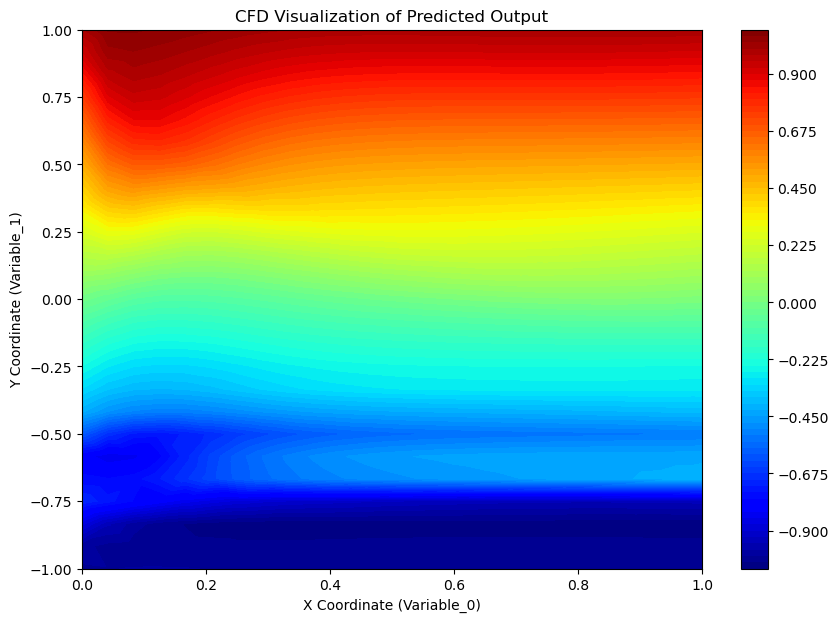

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import os

path = os.getcwd()

# Load the data
points_df = pd.read_csv(os.path.join(path, 'points.csv'))
predicted_output_df = pd.read_csv(os.path.join(path, 'predicted_output.csv'))

# Merge the dataframes if they are aligned by index
df = pd.concat([points_df, predicted_output_df], axis=1)

# Plotting
plt.figure(figsize=(10, 7))
contour = plt.tricontourf(df['Variable_0'][15000:], df['Variable_1'][15000:], df['Prediction'][15000:], levels=100, cmap='jet')
plt.colorbar(contour)
plt.title('CFD Visualization of Predicted Output')
plt.xlabel('X Coordinate (Variable_0)')
plt.ylabel('Y Coordinate (Variable_1)')
plt.show()
